In [1]:
from wordcloud import WordCloud
import pandas as pd 
import numpy as np
import snscrape.modules.twitter as sntwitter 
import datetime 
from tqdm.notebook import tqdm_notebook 
import seaborn as sns 
import itertools
import matplotlib.pyplot as plt
import string
import matplotlib.ticker as mtick
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import text2emotion as te
import demoji
import ast
import time
import warnings
warnings.filterwarnings('ignore')
set(stopwords.words('english'))
sns.set_theme(style="whitegrid") 

C:\Users\Marysia\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marysia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marysia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marysia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Introduction
In this project I will analyse opinions on recently released film, which is a live action remake of The Little Mermaid. This topic is quite controversial because lead actress that plays Ariele, Halle Bailey, is African-American. I will concentrate on four periods of time based on these events: 
1. __official cast reveal__: 2020.12.11
2. __first official trailer__: 2022.09.10
3. __premiere__: 2023.05.26

Tweets with the hashtag __#TheLittleMermaid__, which is official hashtag of the production, will be scrapped in phases. Goal is to scrape at least 50 000 tweets, i will try to scrape them in chronological order.

In [2]:
#function for scrapping tweets
def tweet_scraper(query, n_tweet):
    
    attributes_container = []
    max_tweet = n_tweet

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):

        if i>max_tweet:
            break

        if tweet.lang=='en': #only english tweets
            
            attributes_container.append([tweet.date.date(),
                                         tweet.rawContent]) #only date and content of tweet

    return pd.DataFrame(attributes_container, columns=["Date_Tweet",
                                                       "Tweet"])


In [84]:
#pre cast reveal
tweets1 = tweet_scraper("#TheLittleMermaid until:2020-12-10",15000)
tweets1.to_csv("twt_data_pre_cast.csv")

# two months post cast reveal 
tweets2 = tweet_scraper("#TheLittleMermaid since:2020-12-11 until:2021-02-11",15000)
tweets2.to_csv("twt_data_post_cast.csv")

#one week post trailer reveal
tweets3 = tweet_scraper("#TheLittleMermaid since:2022-09-10 until:2022-09-17", 15000)
tweets3.to_csv("twt_data_post_trailer.csv")

#one week post premiere
tweets4 = tweet_scraper("#TheLittleMermaid since:2023-05-26 until:2023-06-02",15000)
tweets4.to_csv("twt_data_post_premiere.csv")

Unavailable user in card on tweet 1326279268255457280
User 12925072 not found in user refs in card on tweet 1326279268255457280
Unavailable user in card on tweet 1324376722628698112
User 12925072 not found in user refs in card on tweet 1324376722628698112
Unavailable user in card on tweet 1322474219830079493
User 12925072 not found in user refs in card on tweet 1322474219830079493
Unavailable user in card on tweet 1320571661196746753
User 12925072 not found in user refs in card on tweet 1320571661196746753
Unavailable user in card on tweet 1318669147467755520
User 12925072 not found in user refs in card on tweet 1318669147467755520
Unavailable user in card on tweet 1316766580697518080
User 12925072 not found in user refs in card on tweet 1316766580697518080
Unavailable user in card on tweet 1314864077072527360
User 12925072 not found in user refs in card on tweet 1314864077072527360
Unavailable user in card on tweet 1314471538243112962
User 29657655 not found in user refs in card on tw

In [3]:
twt_data1 = pd.read_csv("twt_data_pre_cast.csv")
twt_data2 = pd.read_csv("twt_data_post_cast.csv")
twt_data3 = pd.read_csv("twt_data_post_trailer.csv")
twt_data4 = pd.read_csv("twt_data_post_premiere.csv")

#creating dataset
twt_data = pd.concat([twt_data1,twt_data2,twt_data3,twt_data4], ignore_index=True)

In [4]:
print(twt_data["Tweet"].head())
print("Null values",twt_data["Tweet"].isnull().sum())
print("NA values",twt_data["Tweet"].isna().sum())

0    @MaliaMaunakea LOVE The Little Mermaid! An abs...
1    @4ThePeopleEagle @Strangeland_Elf @MJKPetFish ...
2    @michaelsheen @simonblackwell I thought this w...
3    @ahzookha a couple years ago I uploaded a mash...
4    @imposterfundy Mf shut your big as head up mf ...
Name: Tweet, dtype: object
Null values 0
NA values 0


# Prepocessing

In [5]:
clean = []

#removing !,? from punctuation (sentiment analysers use them)
string.punctuation = string.punctuation.replace('!', '') 
string.punctuation = string.punctuation.replace('?', '')

#removing mentions, links, punctuation
for tweet in twt_data["Tweet"]:
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = " ".join(tweet.split())
    clean.append(tweet)
twt_data["Tweet"] = clean


#tokenizing, lemmatizing and removing stopwords
def preprocess_text(text):

    stop_words = stopwords.words('english') + ['little','mermaid','thelittlemermaid','film','movie','disney',
                                               'im','watch','see','amp','“','’','”','‘','na','go']
    tokens = word_tokenize(text.lower()) #tokenizing
    filtered_tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer() #lemmatizing
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens) #joining in sentences
    
    return processed_text




twt_data['Tweet'] = twt_data['Tweet'].apply(preprocess_text)

twt_data.to_csv("twt_data_clean.csv")

In [6]:
twt_data_clean = pd.read_csv('twt_data_clean.csv')
twt_data_clean["Tweet"].head()

0    love ! absolute classic fabulous soundtrack ! ...
1    logical though imagine parent wanted tell chil...
2    thought referring ursula first know need belti...
3    couple year ago uploaded mashup remix neck bac...
4    mf shut big head mf got red hair watched go wo...
Name: Tweet, dtype: object

# Sentiment

## NLTK Vader

In [7]:
#computating compound score
analyzer = SentimentIntensityAnalyzer()
twt_data_clean['compound'] = twt_data_clean['Tweet'].apply(lambda x:analyzer.polarity_scores(str(x))['compound'])

#setting sentiment based on compound value
twt_data_clean['sentiment'] = twt_data_clean['compound'].apply(lambda x: 'positive' if x >= 0.05 
                                                                       else 'negative' if x <= -0.05  
                                                                       else 'neutral')
#dropping unwanted columns
twt_data_clean.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)
twt_data_clean.head()

,Date_Tweet,Tweet,compound,sentiment
0,2020-12-09,love ! absolute classic fabulous soundtrack ! ...,0.8475,positive
1,2020-12-09,logical though imagine parent wanted tell chil...,0.8271,positive
2,2020-12-09,thought referring ursula first know need belti...,-0.7269,negative
3,2020-12-09,couple year ago uploaded mashup remix neck bac...,0.8016,positive
4,2020-12-09,mf shut big head mf got red hair watched go wo...,0.7645,positive


## text2emotion

In [248]:
#computing emotion scores
twt_data_clean['emotion'] = twt_data_clean['Tweet'].apply(lambda x:te.get_emotion(str(x)))
twt_data_clean.to_csv("twt_data_emotions.csv")

In [8]:
twt_data_clean = pd.read_csv("twt_data_emotions.csv")
print(twt_data_clean['emotion'])

0        {'Happy': 0.71, 'Angry': 0.0, 'Surprise': 0.14...
1        {'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.17...
2        {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.5, ...
3        {'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.0, ...
4        {'Happy': 0.0, 'Angry': 0.3, 'Surprise': 0.5, ...
                               ...                        
52026    {'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':...
52027    {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.33,...
52028    {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.67,...
52029    {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ...
52030    {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.5, ...
Name: emotion, Length: 52031, dtype: object


In [9]:
#text2emotions returns string represantation of dictionary for every sentence

emotions = twt_data_clean['emotion'].apply(lambda x:ast.literal_eval(x)) #getting dictionary from string
emotions = pd.DataFrame(emotions.tolist()) #creating df from dict
emotions

,Happy,Angry,Surprise,Sad,Fear
0,0.71,0.0,0.14,0.00,0.14
1,0.33,0.0,0.17,0.17,0.33
2,0.00,0.0,0.50,0.50,0.00
3,0.50,0.0,0.00,0.00,0.50
4,0.00,0.3,0.50,0.00,0.20
...,...,...,...,...,...
52026,0.00,0.0,0.00,0.00,0.00
52027,0.00,0.0,0.33,0.00,0.67
52028,0.00,0.0,0.67,0.00,0.33
52029,0.00,0.0,0.00,0.25,0.75


In [10]:
#merging emotion df with tweets df
twt_data_emotions = pd.merge(twt_data_clean,emotions,left_index=True, right_index=True)

#cleaning
twt_data_emotions.dropna(inplace=True)
twt_data_emotions.reset_index(inplace = True)
twt_data_emotions.drop(columns=['Unnamed: 0', 'emotion','index'], inplace = True)
twt_data_emotions

,Date_Tweet,Tweet,compound,sentiment,Happy,Angry,Surprise,Sad,Fear
0,2020-12-09,love ! absolute classic fabulous soundtrack ! ...,0.8475,positive,0.71,0.0,0.14,0.00,0.14
1,2020-12-09,logical though imagine parent wanted tell chil...,0.8271,positive,0.33,0.0,0.17,0.17,0.33
2,2020-12-09,thought referring ursula first know need belti...,-0.7269,negative,0.00,0.0,0.50,0.50,0.00
3,2020-12-09,couple year ago uploaded mashup remix neck bac...,0.8016,positive,0.50,0.0,0.00,0.00,0.50
4,2020-12-09,mf shut big head mf got red hair watched go wo...,0.7645,positive,0.00,0.3,0.50,0.00,0.20
...,...,...,...,...,...,...,...,...,...
51356,2023-05-31,filming location,0.0000,neutral,0.00,0.0,0.00,0.00,0.00
51357,2023-05-31,lotr fictional magical story give shit compala...,-0.8442,negative,0.00,0.0,0.33,0.00,0.67
51358,2023-05-31,watched ? genre adventure family fantasy music...,0.3182,positive,0.00,0.0,0.67,0.00,0.33
51359,2023-05-31,ariel caribbean think sister race related ruli...,0.0000,neutral,0.00,0.0,0.00,0.25,0.75


# Opinion analysis

## Overall

In [17]:
#creating datasets for different emotions. If the score is >=0.5 we consider that emotion is present in sentence.
Happy = twt_data_emotions["Tweet"].loc[twt_data_emotions['Happy'] >= 0.5 ]
Angry = twt_data_emotions["Tweet"].loc[twt_data_emotions['Angry'] >= 0.5]
Surprise = twt_data_emotions["Tweet"].loc[twt_data_emotions['Surprise'] >= 0.5]
Sad = twt_data_emotions["Tweet"].loc[twt_data_emotions['Sad'] >=0.5]
Fear = twt_data_emotions["Tweet"].loc[twt_data_emotions['Fear'] >=0.5]

#creating data for barplots- percentage of counts  
bar_em = [Happy.shape[0],Angry.shape[0],Surprise.shape[0],Sad.shape[0],Fear.shape[0]]
bar_em = [i/twt_data_emotions.shape[0] for i in bar_em]

#adding percent of tweets with no emotion detected (no emotion with score >=0.5)
bar_em.append(1-sum(bar_em))

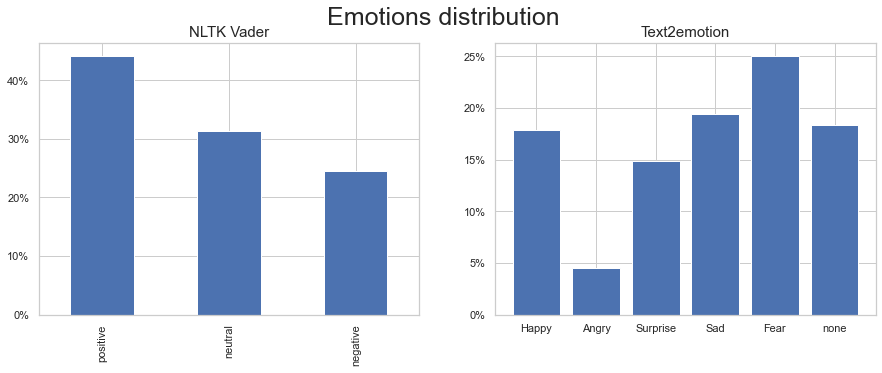

In [20]:
#barplots
sns.set_theme(style="whitegrid")

#emotion labels for text2emotion + none as "no emotion detected"
cols = emotions.columns.tolist()
cols.append('none')

fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (15,5))
(twt_data_clean.sentiment.value_counts()/twt_data_clean.shape[0]).plot(kind='bar', ax = ax1)
ax2.bar(cols, bar_em)
#emotions.mean().plot(kind='bar',ax = ax2)
ax1.set_title("NLTK Vader", fontsize = 15)
ax2.set_title("Text2emotion", fontsize = 15)

vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

fig.suptitle("Emotions distribution", fontsize = 25)
plt.show()

In the first plot we can see that more than 40% of tweets are positive, about 25% negative and the rest are neutral. We can conclude that overall the opinins are positive.
The second barplot shows Fear emotion has the biggest score mean, which means fear was the most detected emotion. According to text2emotion, angry sentiment is the least detected emotion

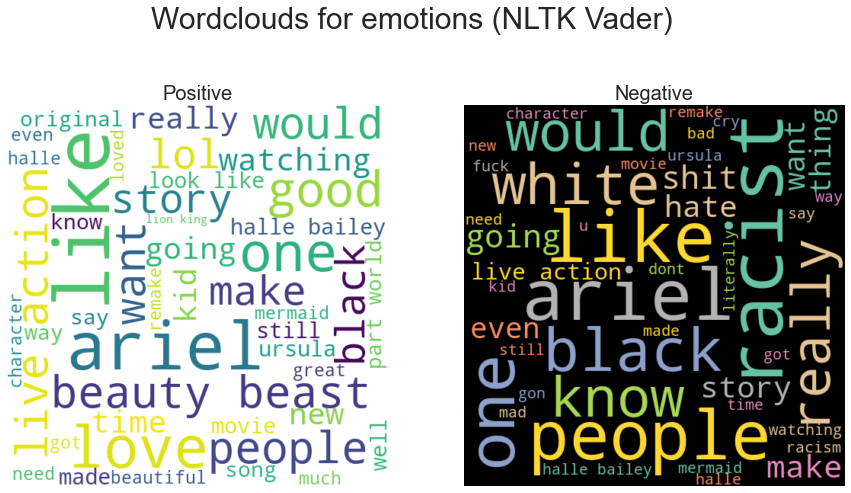

In [21]:
#preparing text for wordcloud, creating one string from all sentences
negative = twt_data_clean["Tweet"].loc[twt_data_clean['sentiment'] == 'negative']
positive = twt_data_clean["Tweet"].loc[twt_data_clean['sentiment'] == 'positive']
neg = " ".join(i for i in negative) 
pos = " ".join(i for i in positive)

plt.rcParams['figure.figsize'] = [15, 15]
fig, axes = plt.subplots()

wordcloud_pos = WordCloud(min_font_size=10, max_font_size=100, width=500,height=500, max_words=45,
                          background_color="white",stopwords = ['!',"?","2","95",'think','get','also']).generate(pos)
wordcloud_neg = WordCloud(min_font_size=10, max_font_size=100, width=500,height=500, max_words=45, colormap = 'Set2',
                          background_color="black",stopwords = ['!',"?","2","95",'think','get','also']).generate(neg)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('Positive', fontsize = 20)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('Negative', fontsize = 20)
fig.suptitle('Wordclouds for emotions (NLTK Vader)', fontsize=30)
fig.subplots_adjust(top=1.3)

plt.show()

Some of the most used words in positive tweets are __like, ariel, love, good, black__. As for negative sentiment in tweets, most shown words are: __racist, like, ariel, white, black__. Word "like" might appear in negative section because its also used in other context such as comparing. We can also see some colocations like halle bailey or live action.

In [22]:
happy_wc = " ".join(i for i in Happy)
angry_wc = " ".join(i for i in Angry)
surprise_wc = " ".join(i for i in Surprise)
sad_wc = " ".join(i for i in Sad)
fear_wc = " ".join(i for i in Fear)

emotions_wc = [happy_wc, angry_wc, surprise_wc, sad_wc, fear_wc]

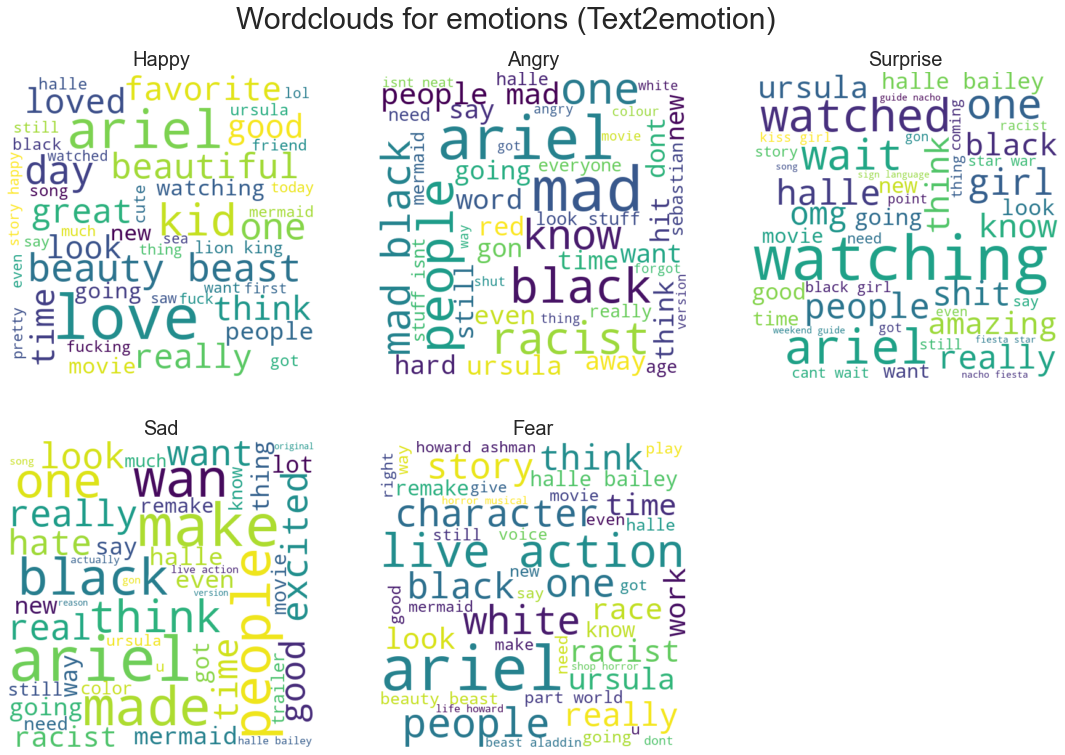

In [24]:
plt.rcParams['figure.figsize'] = [30, 30]
fig,axes = plt.subplots()

wordcloud = WordCloud(min_font_size=10, max_font_size=100, width=500,
                      height=500, max_words=45, background_color="white")

for idx,emotion in enumerate(emotions_wc):

    plt.subplot(5, 3, idx+1)
    plt.imshow(wordcloud.generate(emotion), interpolation="bilinear")
    plt.axis("off")
    plt.title(emotions.columns[idx], fontsize = 20)

plt.subplots_adjust(wspace = -0.6 , hspace=0.2)
fig.suptitle('Wordclouds for emotions (Text2emotion)', fontsize=30)
fig.subplots_adjust(top=0.95)

plt.show()

Change of words is most visible for angry sentiment

## Time

In [25]:
#converting to datetime
twt_data_emotions['Date_Tweet']= pd.to_datetime(twt_data_emotions['Date_Tweet'])

#creating dfs for each time period
pre_cast = twt_data_emotions[twt_data_emotions['Date_Tweet'] < '2020-12-11']
post_cast = twt_data_emotions[(twt_data_emotions['Date_Tweet'] >= '2020-12-11')
                              & (twt_data_emotions['Date_Tweet'] < '2022-09-09')]
post_trailer =twt_data_emotions[(twt_data_emotions['Date_Tweet'] >= '2022-09-09')
                                & (twt_data_emotions['Date_Tweet'] < '2023-05-26')]
post_premiere = twt_data_emotions[twt_data_emotions['Date_Tweet'] >= '2023-05-26']

#calcualtiong mean compound
pre_cast_sent = pre_cast['compound'].mean()
post_cast_sent = post_cast['compound'].mean()
post_trailer_sent = post_trailer['compound'].mean()
post_premiere_sent = post_premiere['compound'].mean()

sentiment_change = [pre_cast_sent, post_cast_sent, post_trailer_sent, post_premiere_sent]
dates = ['Pre cast reveal', 'Post cast reveal', "Post trailer", "Post premiere"]
periods = [pre_cast, post_cast, post_trailer, post_premiere]

In [26]:
#list of distribution of emotions
pos_change = []
neg_change = []
neutr_change = []

for date in periods:
    sum_twts = date.sentiment.value_counts().sum()
    pos_change.append(date.sentiment.value_counts()['positive']/sum_twts)
    neg_change.append(date.sentiment.value_counts()['negative']/sum_twts)
    neutr_change.append(date.sentiment.value_counts()['neutral']/sum_twts)

In [27]:
#list of mean emotion score
happy_change = []
angry_change = []
surprise_change = []
sad_change = []
fear_change = []

for date in periods:
    happy_change.append(date.Happy.mean())
    angry_change.append(date.Angry.mean())
    surprise_change.append(date.Surprise.mean())
    sad_change.append(date.Sad.mean())
    fear_change.append(date.Fear.mean())

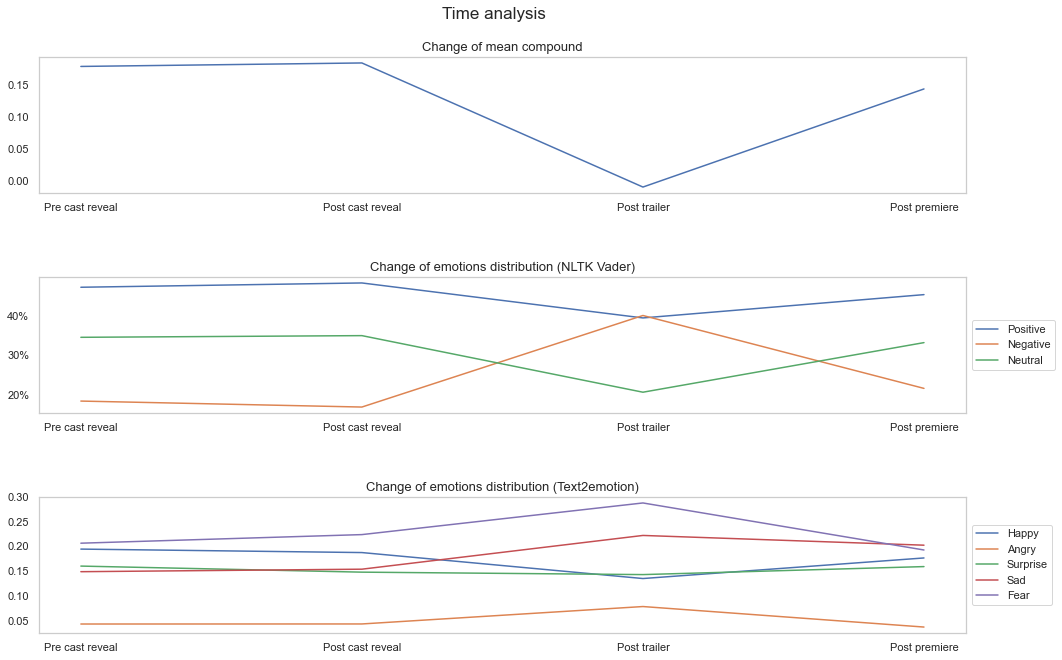

In [29]:
sns.set_style("whitegrid", {'axes.grid' : False})

plt.rcParams['figure.figsize'] = [15, 10]
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.tight_layout(pad=5.0)
fig.suptitle('Time analysis',fontsize = 17)

ax1.plot(dates, sentiment_change)

ax2.plot(dates, pos_change, label = "Positive")
ax2.plot(dates, neg_change, label = "Negative")
ax2.plot(dates, neutr_change, label = "Neutral")

ax3.plot(dates, happy_change, label = "Happy")
ax3.plot(dates, angry_change, label = "Angry")
ax3.plot(dates, surprise_change, label = "Surprise")
ax3.plot(dates, sad_change, label = 'Sad')
ax3.plot(dates, fear_change, label = "Fear")

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax1.set_title("Change of mean compound",fontsize = 13)
ax2.set_title("Change of emotions distribution (NLTK Vader)",fontsize = 13)
ax3.set_title("Change of emotions distribution (Text2emotion)",fontsize = 13)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.show()

Its clear that time trailer reveal was the most triggering event. There were more negative than positive comments

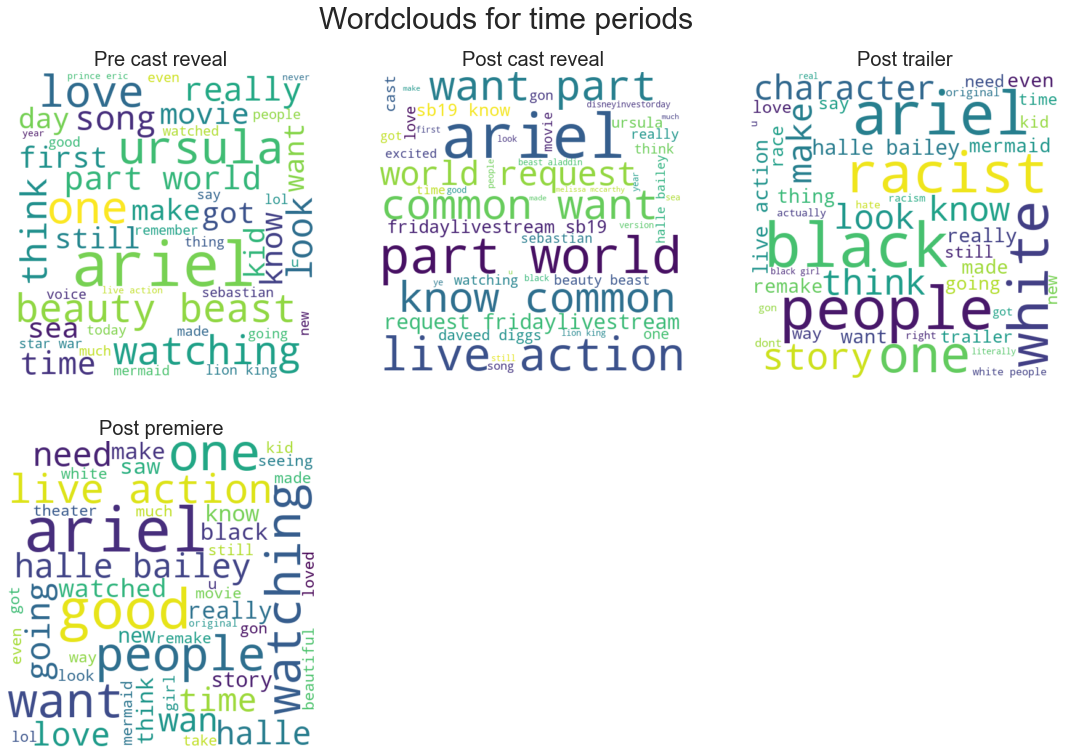

In [284]:
plt.rcParams['figure.figsize'] = [30, 30]
fig,axes = plt.subplots()

wordcloud = WordCloud(min_font_size=10, max_font_size=100, width=500,
                      height=500, max_words=45, background_color="white")

for idx,emotion in enumerate(periods_wc):

    plt.subplot(5, 3, idx+1)
    plt.imshow(wordcloud.generate(emotion), interpolation="bilinear")
    plt.axis("off")
    plt.title(dates[idx], fontsize = 20)

plt.subplots_adjust(wspace = -0.6 , hspace=0.2)
fig.suptitle('Wordclouds for time periods', fontsize=30)
fig.subplots_adjust(top=0.95)

plt.show()

There is visible change in words post trailer reveal. There are a lot of words mentioning race.

# Summary

Overall, it seems that The Little Mermaid was positively received. However there was also significant amount of negative tweets, especially when it comes to time period after trailer reveal. I think that NLTK Vader is much more reliable than text2emotion, which described most tweets as fear charged. This result was quite predictable, as there is significant amount of young and tolerant people on Twitter, and the film is a fiction not a historical document as "Cleopatra". I'm sure that if we would to scrape and analyse facebook posts and comments, most numerous group would be the one with negative sentiment.